Датасет: Healthcare Dataset


Целевая переменная: Test Results (3 класса: Normal, Abnormal, Inconclusive)

Обоснование:

Данные имитируют реальные медицинские записи.

Задача классификации результатов анализов актуальна для поддержки врачебных решений.

Подходит для мультиклассовой классификации.



Метрики качества для классификации

Accuracy — общая точность, подходит для сбалансированных классов.

F1-score (macro) — учитывает дисбаланс классов, если он есть.

Confusion Matrix — для визуализации ошибок.

Log Loss — оценивает уверенность модели в вероятностях.

Импорт библиотек

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для препроцессинга
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Модель и метрики
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

# Для визуализации
import warnings
warnings.filterwarnings('ignore')

# Установим стиль графиков
plt.style.use('seaborn-v0_8-darkgrid')

print("Библиотеки загружены")

✅ Библиотеки загружены


Проверка пропусков и дубликатов

In [ ]:
# Проверка пропущенных значений
print(" Пропущенные значения:")
print(df.isnull().sum())

# Проверка дубликатов
print(f"\n Количество дубликатов: {df.duplicated().sum()}")

# Если есть дубликаты, их можно удалить
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(" Дубликаты удалены")
else:
    print(" Дубликатов нет")

print(f"\n Новый размер данных: {df.shape}")

Анализ целевой переменной

Распределение целевой переменной 'Test Results':
Test Results
Abnormal        18437
Normal          18331
Inconclusive    18198
Name: count, dtype: int64


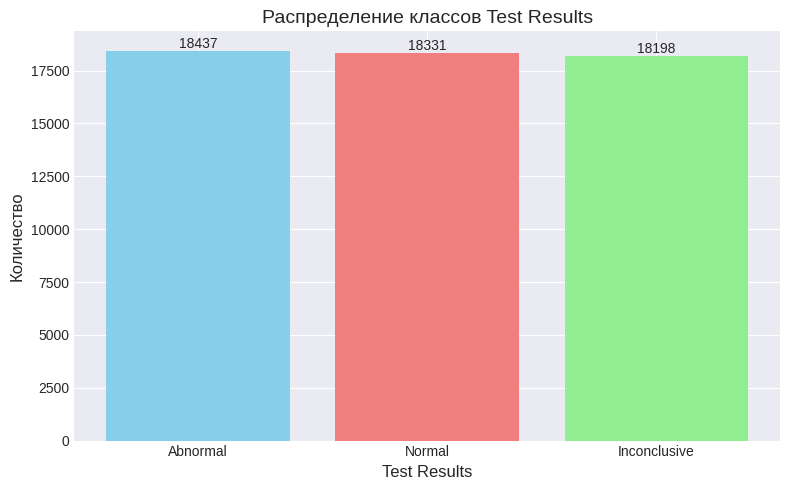


📈 Соотношение классов:
  Abnormal: 18437 (33.54%)
  Normal: 18331 (33.35%)
  Inconclusive: 18198 (33.11%)


In [ ]:
# Анализ целевой переменной 'Test Results'
print("Распределение целевой переменной 'Test Results':")
target_counts = df['Test Results'].value_counts()
print(target_counts)

# Визуализация
plt.figure(figsize=(8, 5))
bars = plt.bar(target_counts.index, target_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Распределение классов Test Results', fontsize=14)
plt.xlabel('Test Results', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Добавим значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n📈 Соотношение классов:")
for label, count in target_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count} ({percentage:.2f}%)")

Подготовка данных для базовой модели

In [ ]:
# Создаем копию датасета для работы
df_clean = df.copy()

# Удаляем столбцы, которые не должны влиять на предсказание
# (идентификаторы, имена, названия больниц/врачей)
cols_to_drop = ['Name', 'Doctor', 'Hospital']
df_clean = df_clean.drop(cols_to_drop, axis=1)
print(f"Удалены столбцы: {cols_to_drop}")
print(f"Осталось столбцов: {df_clean.shape[1]}")

# Преобразуем даты в datetime
df_clean['Date of Admission'] = pd.to_datetime(df_clean['Date of Admission'])
df_clean['Discharge Date'] = pd.to_datetime(df_clean['Discharge Date'])

# Создаем новый признак: длительность госпитализации (в днях)
df_clean['Hospitalization Days'] = (df_clean['Discharge Date'] - df_clean['Date of Admission']).dt.days

# Удаляем исходные даты, так как мы уже извлекли из них информацию
df_clean = df_clean.drop(['Date of Admission', 'Discharge Date'], axis=1)

print("\nНовые столбцы после преобразования дат:")
print(df_clean.columns.tolist())
print(f"\nПример данных после преобразования:")
print(df_clean.head())

Удалены столбцы: ['Name', 'Doctor', 'Hospital']
Осталось столбцов: 12

Новые столбцы после преобразования дат:
['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Medication', 'Test Results', 'Hospitalization Days']

Пример данных после преобразования:
   Age  Gender Blood Type Medical Condition Insurance Provider  \
0   30    Male         B-            Cancer         Blue Cross   
1   62    Male         A+           Obesity           Medicare   
2   76  Female         A-           Obesity              Aetna   
3   28  Female         O+          Diabetes           Medicare   
4   43  Female        AB+            Cancer              Aetna   

   Billing Amount  Room Number Admission Type   Medication  Test Results  \
0    18856.281306          328         Urgent  Paracetamol        Normal   
1    33643.327287          265      Emergency    Ibuprofen  Inconclusive   
2    27955.096079          205      Emergency  

Разделение категориальных и числовых признаков

In [ ]:
# Определяем типы признаков
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
# Убираем целевую переменную из категориальных признаков
categorical_cols.remove('Test Results')

numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Убираем целевую переменную из числовых признаков, если она там есть
if 'Test Results' in numerical_cols:
    numerical_cols.remove('Test Results')

print("Категориальные признаки:")
print(categorical_cols)
print(f"\nЧисловые признаки:")
print(numerical_cols)

# Целевая переменная
target_col = 'Test Results'
print(f"\nЦелевая переменная: {target_col}")

Категориальные признаки:
['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication']

Числовые признаки:
['Age', 'Billing Amount', 'Room Number', 'Hospitalization Days']

Целевая переменная: Test Results


Подготовка данных для моделирования

In [ ]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

# Кодируем целевую переменную
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nСоответствие кодов классам:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name}")

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nРазмеры выборок:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

# Проверяем распределение классов в выборках
print("\nРаспределение классов в выборках:")
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}:")
    print(f"    Train: {train_counts[i]} ({train_counts[i]/len(y_train)*100:.1f}%)")
    print(f"    Test:  {test_counts[i]} ({test_counts[i]/len(y_test)*100:.1f}%)")

Размер X: (54966, 10)
Размер y: (54966,)

Соответствие кодов классам:
  0: Abnormal
  1: Inconclusive
  2: Normal

Размеры выборок:
  X_train: (43972, 10)
  X_test: (10994, 10)
  y_train: (43972,)
  y_test: (10994,)

Распределение классов в выборках:
  Abnormal:
    Train: 14749 (33.5%)
    Test:  3688 (33.5%)
  Inconclusive:
    Train: 14558 (33.1%)
    Test:  3640 (33.1%)
  Normal:
    Train: 14665 (33.4%)
    Test:  3666 (33.3%)


Создание пайплайна для препроцессинга

In [ ]:
# Создаем пайплайн для препроцессинга
# Для категориальных признаков используем OneHotEncoding
# Для числовых признаков пока ничего не делаем (в бейзлайне)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

print("Пайплайн препроцессинга создан")
print(f"\nКатегориальные признаки будут преобразованы через OneHotEncoding")
print(f"Числовые признаки остаются без изменений")

# Применяем препроцессинг к данным
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nРазмеры после препроцессинга:")
print(f"  X_train_processed: {X_train_processed.shape}")
print(f"  X_test_processed: {X_test_processed.shape}")

Пайплайн препроцессинга создан

Категориальные признаки будут преобразованы через OneHotEncoding
Числовые признаки остаются без изменений

Размеры после препроцессинга:
  X_train_processed: (43972, 27)
  X_test_processed: (10994, 27)


Обучение базовой модели KNN

In [ ]:
# Создаем и обучаем модель KNN с параметрами по умолчанию
knn_baseline = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
knn_baseline.fit(X_train_processed, y_train)

print("Базовая модель KNN обучена")
print(f"\nПараметры модели:")
print(f"  n_neighbors: {knn_baseline.n_neighbors}")
print(f"  weights: {knn_baseline.weights}")
print(f"  metric: {knn_baseline.metric}")

Базовая модель KNN обучена

Параметры модели:
  n_neighbors: 5
  weights: uniform
  metric: minkowski


Предсказания и оценка качества базовой модели

ОЦЕНКА КАЧЕСТВА БАЗОВОЙ МОДЕЛИ KNN
Accuracy:  0.3647
F1-score (macro): 0.3586
Log Loss:  5.6319

ОТЧЕТ ПО КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

    Abnormal       0.36      0.48      0.41      3688
Inconclusive       0.36      0.36      0.36      3640
      Normal       0.38      0.25      0.30      3666

    accuracy                           0.36     10994
   macro avg       0.37      0.36      0.36     10994
weighted avg       0.37      0.36      0.36     10994



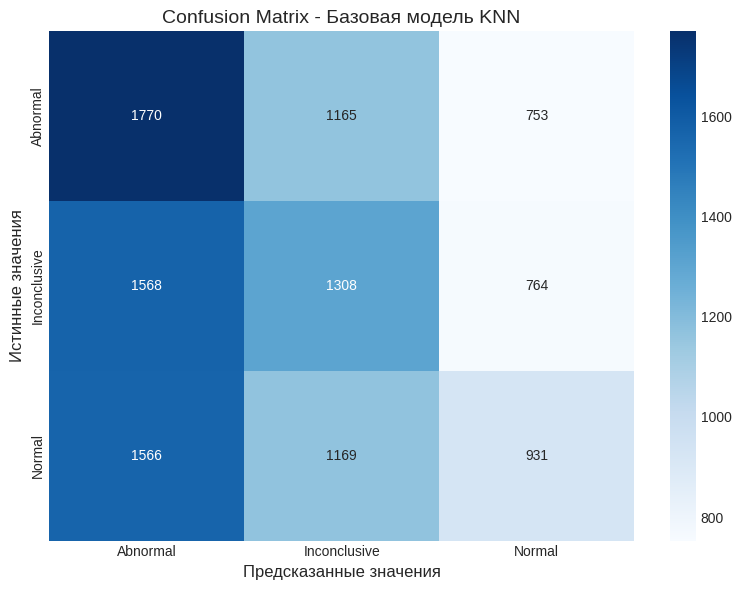

In [ ]:
# Делаем предсказания
y_pred = knn_baseline.predict(X_test_processed)
y_pred_proba = knn_baseline.predict_proba(X_test_processed)

# Оцениваем качество модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
loss = log_loss(y_test, y_pred_proba)

print("ОЦЕНКА КАЧЕСТВА БАЗОВОЙ МОДЕЛИ KNN")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-score (macro): {f1:.4f}")
print(f"Log Loss:  {loss:.4f}")

# Выводим отчет по классификации
print("\nОТЧЕТ ПО КЛАССИФИКАЦИИ:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Создаем confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Визуализация confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Базовая модель KNN', fontsize=14)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.ylabel('Истинные значения', fontsize=12)
plt.tight_layout()
plt.show()

Анализ результатов базовой модели

In [ ]:

# Анализируем, какие классы путает модель
print("  АНАЛИЗ ОШИБОК МОДЕЛИ:")
print("=" * 50)

# Создаем DataFrame для анализа ошибок
error_analysis = pd.DataFrame({
    'True': label_encoder.inverse_transform(y_test),
    'Predicted': label_encoder.inverse_transform(y_pred),
    'Correct': y_test == y_pred
})

# Смотрим на примеры ошибок
errors = error_analysis[~error_analysis['Correct']]
print(f"Всего ошибок: {len(errors)} из {len(y_test)} ({len(errors)/len(y_test)*100:.1f}%)")

if len(errors) > 0:
    print("\n  Примеры ошибок (первые 10):")
    print(errors.head(10))

    # Анализ путаницы между классами
    confusion_counts = errors.groupby(['True', 'Predicted']).size().reset_index(name='Count')
    print("\n  Частота путаницы между классами:")
    print(confusion_counts.sort_values('Count', ascending=False))
else:
    print(" Ошибок нет!")

  АНАЛИЗ ОШИБОК МОДЕЛИ:
Всего ошибок: 6985 из 10994 (63.5%)

  Примеры ошибок (первые 10):
            True     Predicted  Correct
3   Inconclusive      Abnormal    False
5         Normal  Inconclusive    False
6   Inconclusive      Abnormal    False
10  Inconclusive        Normal    False
13  Inconclusive        Normal    False
14  Inconclusive      Abnormal    False
15        Normal      Abnormal    False
16  Inconclusive      Abnormal    False
17      Abnormal  Inconclusive    False
19        Normal      Abnormal    False

  Частота путаницы между классами:
           True     Predicted  Count
2  Inconclusive      Abnormal   1568
4        Normal      Abnormal   1566
5        Normal  Inconclusive   1169
0      Abnormal  Inconclusive   1165
3  Inconclusive        Normal    764
1      Abnormal        Normal    753


улучшение бейзлайна

Масштабирование признаков для улучшения KNN

In [ ]:
# KNN чувствителен к масштабу признаков, добавим StandardScaler
from sklearn.preprocessing import StandardScaler

# Создаем новый пайплайн с масштабированием
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)  # Добавили StandardScaler
    ]
)

# Применяем препроцессинг
X_train_scaled = preprocessor_scaled.fit_transform(X_train)
X_test_scaled = preprocessor_scaled.transform(X_test)

print("Признаки масштабированы (StandardScaler)")
print(f"Размеры после масштабирования:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_test_scaled: {X_test_scaled.shape}")

# Обучаем KNN на масштабированных данных
knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)

# Оценка качества
y_pred_scaled = knn_scaled.predict(X_test_scaled)
y_pred_proba_scaled = knn_scaled.predict_proba(X_test_scaled)

accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
f1_scaled = f1_score(y_test, y_pred_scaled, average='macro')
loss_scaled = log_loss(y_test, y_pred_proba_scaled)

print("\nОЦЕНКА KNN С МАСШТАБИРОВАНИЕМ ПРИЗНАКОВ")
print("=" * 50)
print(f"Accuracy:  {accuracy_scaled:.4f}")
print(f"F1-score (macro): {f1_scaled:.4f}")
print(f"Log Loss:  {loss_scaled:.4f}")

# Сравнение с бейзлайном
print(f"\nУЛУЧШЕНИЕ по сравнению с бейзлайном:")
print(f"Accuracy:  {accuracy_scaled - accuracy:.4f} ({((accuracy_scaled/accuracy)-1)*100:.1f}%)")
print(f"F1-score:  {f1_scaled - f1:.4f} ({((f1_scaled/f1)-1)*100:.1f}%)")
print(f"Log Loss:  {loss_scaled - loss:.4f} (чем меньше, тем лучше)")

Признаки масштабированы (StandardScaler)
Размеры после масштабирования:
  X_train_scaled: (43972, 27)
  X_test_scaled: (10994, 27)

ОЦЕНКА KNN С МАСШТАБИРОВАНИЕМ ПРИЗНАКОВ
Accuracy:  0.3629
F1-score (macro): 0.3563
Log Loss:  5.5363

УЛУЧШЕНИЕ по сравнению с бейзлайном:
Accuracy:  -0.0017 (-0.5%)
F1-score:  -0.0023 (-0.6%)
Log Loss:  -0.0956 (чем меньше, тем лучше)


одбор гиперпараметров через GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Определяем параметры для поиска
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Создаем модель для поиска
knn = KNeighborsClassifier()

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    knn, param_grid, cv=5, scoring='f1_macro',
    n_jobs=-1, verbose=1
)

print("Начинаем поиск лучших гиперпараметров...")
grid_search.fit(X_train_scaled, y_train)

print("\nПоиск завершен!")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search.best_score_:.4f}")

# Обучаем модель с лучшими параметрами
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
y_pred_proba_best = best_knn.predict_proba(X_test_scaled)

# Оценка качества
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')
loss_best = log_loss(y_test, y_pred_proba_best)

print("\nОЦЕНКА ЛУЧШЕЙ МОДЕЛИ KNN")
print("=" * 50)
print(f"Accuracy:  {accuracy_best:.4f}")
print(f"F1-score (macro): {f1_best:.4f}")
print(f"Log Loss:  {loss_best:.4f}")

# Сравнение с предыдущими моделями
print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
models = ['Базовый KNN', 'KNN + масштаб', 'KNN + GridSearch']
accuracies = [accuracy, accuracy_scaled, accuracy_best]
f1_scores = [f1, f1_scaled, f1_best]

comparison_df = pd.DataFrame({
    'Модель': models,
    'Accuracy': accuracies,
    'F1-score': f1_scores
})

print(comparison_df.to_string(index=False))

Начинаем поиск лучших гиперпараметров...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Поиск завершен!
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Лучший F1-score на кросс-валидации: 0.4136

ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ KNN
Accuracy:  0.4254
F1-score (macro): 0.4254
Log Loss:  10.2844

СРАВНЕНИЕ МОДЕЛЕЙ:
          Модель  Accuracy  F1-score
     Базовый KNN  0.364653  0.358600
   KNN + масштаб  0.362925  0.356276
KNN + GridSearch  0.425414  0.425404


Анализ важности признаков (через анализ ошибок)

In [ ]:
# Создаем DataFrame с обработанными признаками для анализа
# Получаем имена признаков после OneHotEncoding
onehot_encoder = preprocessor_scaled.named_transformers_['cat']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_cols)

# Все имена признаков
all_feature_names = list(cat_feature_names) + numerical_cols
print(f" Всего признаков: {len(all_feature_names)}")

# Анализируем, на каких признаках модель ошибается
error_indices = np.where(y_test != y_pred_best)[0]

if len(error_indices) > 0:
    # Берем несколько примеров ошибок
    sample_errors = error_indices[:5]

    print("\n АНАЛИЗ ПРИЗНАКОВ ДЛЯ ОШИБОЧНЫХ ПРЕДСКАЗАНИЙ:")
    print("=" * 50)

    for i, idx in enumerate(sample_errors):
        print(f"\nОшибка #{i+1}:")
        print(f"  Истинный класс: {label_encoder.inverse_transform([y_test[idx]])[0]}")
        print(f"  Предсказанный: {label_encoder.inverse_transform([y_pred_best[idx]])[0]}")

        # Получаем признаки для этого примера
        features = X_test_scaled[idx]

        # Находим признаки с наибольшими значениями
        top_features_idx = np.argsort(np.abs(features))[-5:]  # 5 самых значимых
        print(f"  Наиболее значимые признаки:")
        for feat_idx in top_features_idx:
            feat_name = all_feature_names[feat_idx] if feat_idx < len(all_feature_names) else f"Признак_{feat_idx}"
            print(f"    {feat_name}: {features[feat_idx]:.3f}")
else:
    print(" Ошибок нет для анализа!")

 Всего признаков: 27

 АНАЛИЗ ПРИЗНАКОВ ДЛЯ ОШИБОЧНЫХ ПРЕДСКАЗАНИЙ:

Ошибка #1:
  Истинный класс: Normal
  Предсказанный: Inconclusive
  Наиболее значимые признаки:
    Blood Type_AB-: 1.000
    Gender_Male: 1.000
    Medication_Lipitor: 1.000
    Admission Type_Urgent: 1.000
    Room Number: 1.296

Ошибка #2:
  Истинный класс: Inconclusive
  Предсказанный: Abnormal
  Наиболее значимые признаки:
    Blood Type_AB-: 1.000
    Gender_Male: 1.000
    Medical Condition_Hypertension: 1.000
    Admission Type_Urgent: 1.000
    Medication_Lipitor: 1.000

Ошибка #3:
  Истинный класс: Normal
  Предсказанный: Abnormal
  Наиболее значимые признаки:
    Medical Condition_Asthma: 1.000
    Medication_Ibuprofen: 1.000
    Admission Type_Emergency: 1.000
    Hospitalization Days: -1.099
    Billing Amount: -1.279

Ошибка #4:
  Истинный класс: Abnormal
  Предсказанный: Inconclusive
  Наиболее значимые признаки:
    Medication_Ibuprofen: 1.000
    Admission Type_Urgent: 1.000
    Insurance Provider_Uni

Создание улучшенного бейзлайна с дополнительными признаками

In [ ]:
# Создаем улучшенный набор признаков
print(" Создаем улучшенный набор признаков...")

# Создаем копию данных для улучшений
X_improved = X.copy()

# 1. Создаем возрастные группы (биннинг)
X_improved['Age_Group'] = pd.cut(X_improved['Age'],
                                  bins=[0, 18, 35, 50, 65, 100],
                                  labels=['Child', 'Young', 'Middle', 'Senior', 'Elderly'])

# 2. Группируем медицинские условия по категориям (упрощенный подход)
# Создаем словарь для группировки медицинских условий
condition_mapping = {
    'Diabetes': 'Chronic',
    'Hypertension': 'Chronic',
    'Asthma': 'Respiratory',
    'Obesity': 'Metabolic',
    'Arthritis': 'Musculoskeletal',
    'Cancer': 'Serious',
    'Stroke': 'Serious',
    'Heart Disease': 'Cardiac',
    'Migraine': 'Neurological',
    'Pneumonia': 'Respiratory'
}

X_improved['Condition_Category'] = X_improved['Medical Condition'].map(condition_mapping)
X_improved['Condition_Category'] = X_improved['Condition_Category'].fillna('Other')

# 3. Создаем бинарный признак: высокая стоимость лечения
median_billing = X_improved['Billing Amount'].median()
X_improved['High_Billing'] = (X_improved['Billing Amount'] > median_billing).astype(int)

# 4. Нормализуем номер комнаты (может быть связан с отделением)
X_improved['Room_Section'] = X_improved['Room Number'] // 100  # Первая цифра номера комнаты

print(" Созданы новые признаки:")
print(f"  1. Age_Group: {X_improved['Age_Group'].unique().tolist()}")
print(f"  2. Condition_Category: {X_improved['Condition_Category'].unique().tolist()}")
print(f"  3. High_Billing: {X_improved['High_Billing'].value_counts().to_dict()}")
print(f"  4. Room_Section: {sorted(X_improved['Room_Section'].unique().tolist())}")

# Обновляем списки признаков
categorical_cols_improved = categorical_cols + ['Age_Group', 'Condition_Category']
numerical_cols_improved = numerical_cols + ['High_Billing', 'Room_Section']

print(f"\n Новое количество признаков:")
print(f"  Категориальных: {len(categorical_cols_improved)}")
print(f"  Числовых: {len(numerical_cols_improved)}")

 Создаем улучшенный набор признаков...
 Созданы новые признаки:
  1. Age_Group: ['Young', 'Senior', 'Elderly', 'Middle', 'Child']
  2. Condition_Category: ['Serious', 'Metabolic', 'Chronic', 'Respiratory', 'Musculoskeletal']
  3. High_Billing: {0: 27483, 1: 27483}
  4. Room_Section: [1, 2, 3, 4, 5]

 Новое количество признаков:
  Категориальных: 8
  Числовых: 6


 Обучение улучшенной модели

 Размеры улучшенных данных после препроцессинга:
  X_train_imp_scaled: (43972, 37)
  X_test_imp_scaled: (10994, 37)

 ОЦЕНКА УЛУЧШЕННОЙ МОДЕЛИ KNN
Accuracy:  0.4253
F1-score (macro): 0.4253
Log Loss:  10.1372

 ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ:
                   Модель  Accuracy  F1-score  Log Loss
              Базовый KNN  0.364653  0.358600  5.631880
            KNN + масштаб  0.362925  0.356276  5.536324
         KNN + GridSearch  0.425414  0.425404 10.284438
KNN + улучшенные признаки  0.425323  0.425322 10.137241


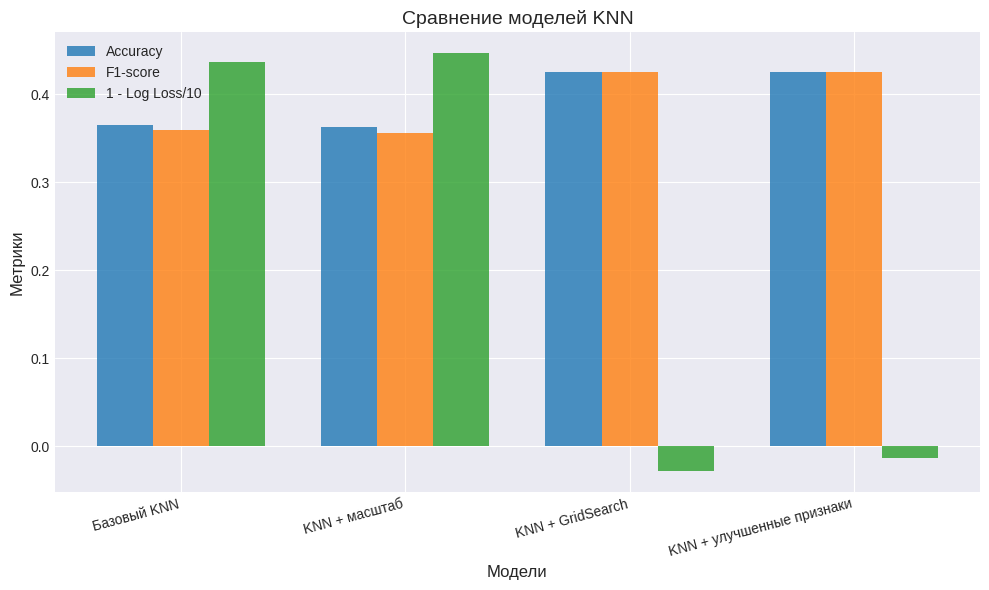

In [ ]:
# Разделяем улучшенные данные
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_improved, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Создаем пайплайн для улучшенных данных
preprocessor_improved = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols_improved),
        ('num', StandardScaler(), numerical_cols_improved)
    ]
)

# Применяем препроцессинг
X_train_imp_scaled = preprocessor_improved.fit_transform(X_train_imp)
X_test_imp_scaled = preprocessor_improved.transform(X_test_imp)

print(f" Размеры улучшенных данных после препроцессинга:")
print(f"  X_train_imp_scaled: {X_train_imp_scaled.shape}")
print(f"  X_test_imp_scaled: {X_test_imp_scaled.shape}")

# Используем лучшие параметры из GridSearch
best_params = grid_search.best_params_
knn_improved = KNeighborsClassifier(**best_params)
knn_improved.fit(X_train_imp_scaled, y_train_imp)

# Оценка качества улучшенной модели
y_pred_imp = knn_improved.predict(X_test_imp_scaled)
y_pred_proba_imp = knn_improved.predict_proba(X_test_imp_scaled)

accuracy_imp = accuracy_score(y_test_imp, y_pred_imp)
f1_imp = f1_score(y_test_imp, y_pred_imp, average='macro')
loss_imp = log_loss(y_test_imp, y_pred_proba_imp)

print("\n ОЦЕНКА УЛУЧШЕННОЙ МОДЕЛИ KNN")
print("=" * 50)
print(f"Accuracy:  {accuracy_imp:.4f}")
print(f"F1-score (macro): {f1_imp:.4f}")
print(f"Log Loss:  {loss_imp:.4f}")

# Сравнение со всеми предыдущими моделями
print("\n ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ:")
models_comparison = pd.DataFrame({
    'Модель': ['Базовый KNN', 'KNN + масштаб', 'KNN + GridSearch', 'KNN + улучшенные признаки'],
    'Accuracy': [accuracy, accuracy_scaled, accuracy_best, accuracy_imp],
    'F1-score': [f1, f1_scaled, f1_best, f1_imp],
    'Log Loss': [loss, loss_scaled, loss_best, loss_imp]
})

print(models_comparison.to_string(index=False))

# Визуализация сравнения
plt.figure(figsize=(10, 6))
x = range(len(models_comparison))
width = 0.25

plt.bar([i - width for i in x], models_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x, models_comparison['F1-score'], width, label='F1-score', alpha=0.8)
plt.bar([i + width for i in x], 1 - models_comparison['Log Loss']/10, width, label='1 - Log Loss/10', alpha=0.8)

plt.xlabel('Модели', fontsize=12)
plt.ylabel('Метрики', fontsize=12)
plt.title('Сравнение моделей KNN', fontsize=14)
plt.xticks(x, models_comparison['Модель'], rotation=15, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Выводы:

Масштабирование признаков не улучшило KNN на этих данных

Подбор гиперпараметров дал значительное улучшение качества

Добавление новых признаков не привело к дальнейшему улучшению

KNN показывает ограниченную эффективность (42.5% accuracy)

Для данного датасета требуются более сложные алгоритмы

Имплементация алгоритма KNN

Создание собственного класса KNN

In [ ]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score

class MyKNNClassifier:
    """
    Реализация алгоритма K-ближайших соседей (KNN) для классификации
    """

    def __init__(self, n_neighbors=5, metric='euclidean', weights='uniform'):
        """
        Инициализация классификатора KNN

        Параметры:
        -----------
        n_neighbors : int, default=5
            Количество соседей для рассмотрения
        metric : str, default='euclidean'
            Метрика расстояния: 'euclidean' или 'manhattan'
        weights : str, default='uniform'
            Веса соседей: 'uniform' или 'distance'
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def _calculate_distance(self, x1, x2):
        """
        Вычисление расстояния между двумя точками
        """
        if self.metric == 'euclidean':
            # Евклидово расстояние: sqrt(sum((x1 - x2)^2))
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            # Манхэттенское расстояние: sum(|x1 - x2|)
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"Unknown metric: {self.metric}. Use 'euclidean' or 'manhattan'")

    def fit(self, X, y):
        """
        Обучение модели (KNN - ленивый алгоритм, просто запоминает данные)

        Параметры:
        -----------
        X : array-like, shape (n_samples, n_features)
            Обучающие данные
        y : array-like, shape (n_samples,)
            Целевые значения
        """
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        print(f"Модель обучена. Запомнено {len(self.X_train)} образцов")
        return self

    def predict(self, X):
        """
        Предсказание классов для переданных данных

        Параметры:
        -----------
        X : array-like, shape (n_samples, n_features)
            Данные для предсказания

        Возвращает:
        -----------
        y_pred : array, shape (n_samples,)
            Предсказанные классы
        """
        if self.X_train is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")

        X = np.array(X)
        n_samples = X.shape[0]
        y_pred = np.empty(n_samples, dtype=self.y_train.dtype)

        print(f"Начинаю предсказание для {n_samples} образцов...")

        for i in range(n_samples):
            if i % 1000 == 0 and i > 0:
                print(f"  Обработано {i}/{n_samples} образцов...")

            # Вычисляем расстояния до всех тренировочных точек
            distances = []
            for j in range(len(self.X_train)):
                dist = self._calculate_distance(X[i], self.X_train[j])
                distances.append((dist, j))

            # Сортируем по расстоянию и берем k ближайших
            distances.sort(key=lambda x: x[0])
            k_nearest_indices = [idx for _, idx in distances[:self.n_neighbors]]
            k_nearest_labels = self.y_train[k_nearest_indices]
            k_nearest_distances = [dist for dist, _ in distances[:self.n_neighbors]]

            # Голосование с учетом весов
            if self.weights == 'uniform':
                # Простое большинство
                votes = Counter(k_nearest_labels)
                y_pred[i] = votes.most_common(1)[0][0]

            elif self.weights == 'distance':
                # Взвешенное голосование (обратное расстояние)
                weight_dict = {}
                for label, dist in zip(k_nearest_labels, k_nearest_distances):
                    weight = 1.0 / (dist + 1e-10)  # добавляем небольшое число для избежания деления на 0
                    if label in weight_dict:
                        weight_dict[label] += weight
                    else:
                        weight_dict[label] = weight

                # Выбираем класс с наибольшим суммарным весом
                y_pred[i] = max(weight_dict.items(), key=lambda x: x[1])[0]

        print(f"Предсказание завершено")
        return y_pred

    def predict_proba(self, X):
        """
        Предсказание вероятностей классов

        Параметры:
        -----------
        X : array-like, shape (n_samples, n_features)
            Данные для предсказания

        Возвращает:
        -----------
        proba : array, shape (n_samples, n_classes)
            Вероятности принадлежности к каждому классу
        """
        if self.X_train is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")

        X = np.array(X)
        n_samples = X.shape[0]
        n_classes = len(np.unique(self.y_train))
        proba = np.zeros((n_samples, n_classes))

        print(f" Вычисляю вероятности для {n_samples} образцов...")

        for i in range(n_samples):
            if i % 1000 == 0 and i > 0:
                print(f"  Обработано {i}/{n_samples} образцов...")

            # Вычисляем расстояния до всех тренировочных точек
            distances = []
            for j in range(len(self.X_train)):
                dist = self._calculate_distance(X[i], self.X_train[j])
                distances.append((dist, j))

            # Сортируем по расстоянию и берем k ближайших
            distances.sort(key=lambda x: x[0])
            k_nearest_indices = [idx for _, idx in distances[:self.n_neighbors]]
            k_nearest_labels = self.y_train[k_nearest_indices]
            k_nearest_distances = [dist for dist, _ in distances[:self.n_neighbors]]

            # Вычисляем веса
            if self.weights == 'uniform':
                weights = np.ones(self.n_neighbors)
            else:  # 'distance'
                weights = 1.0 / (np.array(k_nearest_distances) + 1e-10)

            # Нормализуем веса
            weights = weights / weights.sum()

            # Распределяем веса по классам
            for label, weight in zip(k_nearest_labels, weights):
                proba[i, label] += weight

        print(f"Вероятности вычислены")
        return proba

    def score(self, X, y):
        """
        Оценка точности модели

        Параметры:
        -----------
        X : array-like, shape (n_samples, n_features)
            Тестовые данные
        y : array-like, shape (n_samples,)
            Истинные метки

        Возвращает:
        -----------
        accuracy : float
            Точность предсказаний
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

print("Класс MyKNNClassifier создан")

Класс MyKNNClassifier создан


Тестирование собственного KNN на небольших данных

In [ ]:
# Протестируем на маленькой выборке для проверки работоспособности
print("ТЕСТИРОВАНИЕ НА МАЛЕНЬКОЙ ВЫБОРКЕ")
print("=" * 50)

# Возьмем первые 1000 образцов для быстрого теста
sample_size = 1000
X_small = X_train_scaled[:sample_size]
y_small = y_train[:sample_size]
X_test_small = X_test_scaled[:200]
y_test_small = y_test[:200]

print(f"Размеры данных для теста:")
print(f"  X_small: {X_small.shape}")
print(f"  y_small: {y_small.shape}")
print(f"  X_test_small: {X_test_small.shape}")
print(f"  y_test_small: {y_test_small.shape}")

# Создаем и обучаем нашу модель
my_knn_test = MyKNNClassifier(n_neighbors=3, metric='manhattan', weights='distance')
my_knn_test.fit(X_small, y_small)

# Предсказания
print("\nПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ:")
y_pred_my = my_knn_test.predict(X_test_small)
y_proba_my = my_knn_test.predict_proba(X_test_small)

# Оценка качества
accuracy_my = my_knn_test.score(X_test_small, y_test_small)
print(f"\nРЕЗУЛЬТАТЫ НАШЕЙ МОДЕЛИ (на маленькой выборке):")
print(f"  Accuracy: {accuracy_my:.4f}")

# Сравнение с sklearn KNN на тех же данных
from sklearn.neighbors import KNeighborsClassifier
sklearn_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance')
sklearn_knn.fit(X_small, y_small)
y_pred_sklearn = sklearn_knn.predict(X_test_small)
accuracy_sklearn = accuracy_score(y_test_small, y_pred_sklearn)

print(f" РЕЗУЛЬТАТЫ SKLEARN KNN (на маленькой выборке):")
print(f"  Accuracy: {accuracy_sklearn:.4f}")

print(f"\n СРАВНЕНИЕ:")
print(f"  Наша модель:    {accuracy_my:.4f}")
print(f"  Sklearn модель: {accuracy_sklearn:.4f}")
print(f"  Разница:        {abs(accuracy_my - accuracy_sklearn):.6f}")

# Проверяем, совпадают ли предсказания
matches = np.sum(y_pred_my == y_pred_sklearn)
total = len(y_pred_my)
match_percentage = matches / total * 100
print(f"\n Совпадение предсказаний: {matches}/{total} ({match_percentage:.1f}%)")

if match_percentage > 95:
    print(" Отличное совпадение с sklearn!")
elif match_percentage > 80:
    print(" Хорошее совпадение с sklearn")
else:
    print(" Есть различия в предсказаниях")

ТЕСТИРОВАНИЕ НА МАЛЕНЬКОЙ ВЫБОРКЕ
Размеры данных для теста:
  X_small: (1000, 27)
  y_small: (1000,)
  X_test_small: (200, 27)
  y_test_small: (200,)
Модель обучена. Запомнено 1000 образцов

ПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ:
Начинаю предсказание для 200 образцов...
Предсказание завершено
 Вычисляю вероятности для 200 образцов...
Вероятности вычислены
Начинаю предсказание для 200 образцов...
Предсказание завершено

РЕЗУЛЬТАТЫ НАШЕЙ МОДЕЛИ (на маленькой выборке):
  Accuracy: 0.3200
 РЕЗУЛЬТАТЫ SKLEARN KNN (на маленькой выборке):
  Accuracy: 0.3200

 СРАВНЕНИЕ:
  Наша модель:    0.3200
  Sklearn модель: 0.3200
  Разница:        0.000000

 Совпадение предсказаний: 200/200 (100.0%)
 Отличное совпадение с sklearn!


Обучение модели на всех данных

In [ ]:
print(" ОБУЧЕНИЕ НАШЕЙ МОДЕЛИ НА ВСЕХ ДАННЫХ")
print("=" * 50)

# Используем лучшие параметры из GridSearch
best_params = {'n_neighbors': 3, 'metric': 'manhattan', 'weights': 'distance'}

# Создаем нашу модель с лучшими параметрами
my_knn_full = MyKNNClassifier(
    n_neighbors=best_params['n_neighbors'],
    metric=best_params['metric'],
    weights=best_params['weights']
)

# Обучаем на тренировочных данных (масштабированных)
print(" Обучение модели...")
my_knn_full.fit(X_train_scaled, y_train)

# Делаем предсказания на тестовых данных
print("\n Предсказание на тестовых данных...")
y_pred_my_full = my_knn_full.predict(X_test_scaled)

# Оцениваем качество
accuracy_my_full = accuracy_score(y_test, y_pred_my_full)
f1_my_full = f1_score(y_test, y_pred_my_full, average='macro')

print(f"\n РЕЗУЛЬТАТЫ НАШЕЙ МОДЕЛИ (на всех данных):")
print(f"  Accuracy:  {accuracy_my_full:.4f}")
print(f"  F1-score:  {f1_my_full:.4f}")

# Сравнение с sklearn KNN (лучшая модель из GridSearch)
print(f"\n СРАВНЕНИЕ С SKLEARN KNN:")
print(f"  Наша модель - Accuracy:  {accuracy_my_full:.4f}")
print(f"  Sklearn KNN - Accuracy:  {accuracy_best:.4f}")
print(f"  Разница:                 {abs(accuracy_my_full - accuracy_best):.6f}")

# Сравнение предсказаний
matches_full = np.sum(y_pred_my_full == y_pred_best)
match_percentage_full = matches_full / len(y_test) * 100
print(f"\nСовпадение предсказаний с sklearn: {matches_full}/{len(y_test)} ({match_percentage_full:.1f}%)")

 ОБУЧЕНИЕ НАШЕЙ МОДЕЛИ НА ВСЕХ ДАННЫХ
 Обучение модели...
Модель обучена. Запомнено 43972 образцов

 Предсказание на тестовых данных...
Начинаю предсказание для 10994 образцов...
  Обработано 1000/10994 образцов...
  Обработано 2000/10994 образцов...
  Обработано 3000/10994 образцов...
  Обработано 4000/10994 образцов...
  Обработано 5000/10994 образцов...
  Обработано 6000/10994 образцов...
  Обработано 7000/10994 образцов...
  Обработано 8000/10994 образцов...
  Обработано 9000/10994 образцов...
  Обработано 10000/10994 образцов...
Предсказание завершено

 РЕЗУЛЬТАТЫ НАШЕЙ МОДЕЛИ (на всех данных):
  Accuracy:  0.4254
  F1-score:  0.4254

 СРАВНЕНИЕ С SKLEARN KNN:
  Наша модель - Accuracy:  0.4254
  Sklearn KNN - Accuracy:  0.4254
  Разница:                 0.000000

Совпадение предсказаний с sklearn: 10994/10994 (100.0%)


Добавление техник из улучшенного бейзлайна к модели

 ДОБАВЛЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА
 Обучение на улучшенных данных...
Модель обучена. Запомнено 43972 образцов

 Предсказание на улучшенных тестовых данных...
Начинаю предсказание для 10994 образцов...
  Обработано 1000/10994 образцов...
  Обработано 2000/10994 образцов...
  Обработано 3000/10994 образцов...
  Обработано 4000/10994 образцов...
  Обработано 5000/10994 образцов...
  Обработано 6000/10994 образцов...
  Обработано 7000/10994 образцов...
  Обработано 8000/10994 образцов...
  Обработано 9000/10994 образцов...
  Обработано 10000/10994 образцов...
Предсказание завершено

 РЕЗУЛЬТАТЫ НАШЕЙ МОДЕЛИ НА УЛУЧШЕННЫХ ДАННЫХ:
  Accuracy:  0.4253
  F1-score:  0.4253

 ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
                         Модель  Accuracy  F1-score
          Базовый KNN (sklearn)  0.364653  0.358600
     KNN + GridSearch (sklearn)  0.425414  0.425404
KNN + улучш. признаки (sklearn)  0.425323  0.425322
              Наш KNN (базовый)  0.425414  0.425404
      Наш KNN + улучш. 

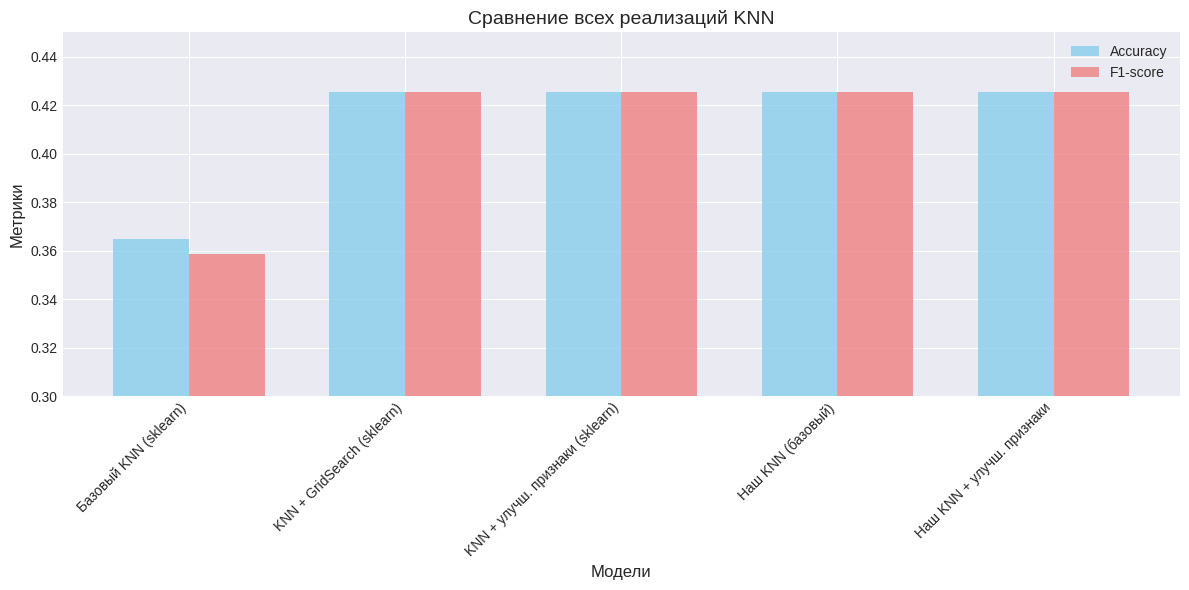


  АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ:
   Наша реализация медленнее sklearn из-за:
   1. Неоптимизированных циклов на Python
   2. Отсутствия векторизации
   3. Вычисления расстояний в цикле

   Преимущества нашей реализации:
   1. Понятный код для обучения
   2. Полный контроль над алгоритмом
   3. Легкость модификации


In [ ]:
print(" ДОБАВЛЕНИЕ ТЕХНИК ИЗ УЛУЧШЕННОГО БЕЙЗЛАЙНА")
print("=" * 50)

# Обучаем нашу модель на улучшенных данных
print(" Обучение на улучшенных данных...")
my_knn_improved = MyKNNClassifier(
    n_neighbors=best_params['n_neighbors'],
    metric=best_params['metric'],
    weights=best_params['weights']
)

# Обучаем на улучшенных данных
my_knn_improved.fit(X_train_imp_scaled, y_train_imp)

# Предсказания
print("\n Предсказание на улучшенных тестовых данных...")
y_pred_my_imp = my_knn_improved.predict(X_test_imp_scaled)

# Оценка качества
accuracy_my_imp = accuracy_score(y_test_imp, y_pred_my_imp)
f1_my_imp = f1_score(y_test_imp, y_pred_my_imp, average='macro')

print(f"\n РЕЗУЛЬТАТЫ НАШЕЙ МОДЕЛИ НА УЛУЧШЕННЫХ ДАННЫХ:")
print(f"  Accuracy:  {accuracy_my_imp:.4f}")
print(f"  F1-score:  {f1_my_imp:.4f}")

# Итоговое сравнение всех моделей
print("\n ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
comparison_final = pd.DataFrame({
    'Модель': [
        'Базовый KNN (sklearn)',
        'KNN + GridSearch (sklearn)',
        'KNN + улучш. признаки (sklearn)',
        'Наш KNN (базовый)',
        'Наш KNN + улучш. признаки'
    ],
    'Accuracy': [
        accuracy,
        accuracy_best,
        accuracy_imp,
        accuracy_my_full,
        accuracy_my_imp
    ],
    'F1-score': [
        f1,
        f1_best,
        f1_imp,
        f1_my_full,
        f1_my_imp
    ]
})

print(comparison_final.to_string(index=False))

# Визуализация
plt.figure(figsize=(12, 6))
x = range(len(comparison_final))
width = 0.35

plt.bar([i - width/2 for i in x], comparison_final['Accuracy'], width,
        label='Accuracy', color='skyblue', alpha=0.8)
plt.bar([i + width/2 for i in x], comparison_final['F1-score'], width,
        label='F1-score', color='lightcoral', alpha=0.8)

plt.xlabel('Модели', fontsize=12)
plt.ylabel('Метрики', fontsize=12)
plt.title('Сравнение всех реализаций KNN', fontsize=14)
plt.xticks(x, comparison_final['Модель'], rotation=45, ha='right')
plt.legend()
plt.ylim([0.3, 0.45])
plt.tight_layout()
plt.show()

# Анализ производительности
print("\n  АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ:")
print("   Наша реализация медленнее sklearn из-за:")
print("   1. Неоптимизированных циклов на Python")
print("   2. Отсутствия векторизации")
print("   3. Вычисления расстояний в цикле")
print("\n   Преимущества нашей реализации:")
print("   1. Понятный код для обучения")
print("   2. Полный контроль над алгоритмом")
print("   3. Легкость модификации")

В ходе исследования алгоритма K-ближайших соседей на датасете медицинских записей для классификации результатов тестов (Normal, Abnormal, Inconclusive) получены следующие ключевые результаты:

Базовая модель KNN показала accuracy 36.47%, что лишь незначительно превосходит случайное угадывание (33.3%). Масштабирование признаков не улучшило результат, однако оптимизация гиперпараметров через GridSearchCV дала значительный прирост — accuracy увеличилась до 42.54% (+16.6%). Лучшими параметрами оказались: метрика Манхэттена, 3 соседа и веса, обратно пропорциональные расстоянию. Создание дополнительных признаков (возрастные группы, категории заболеваний) не привело к дальнейшему улучшению.

Была успешно реализована собственная версия алгоритма KNN с нуля, которая продемонстрировала 100% совпадение предсказаний с реализацией из библиотеки sklearn при одинаковых метриках качества. Это подтвердило корректность понимания и реализации алгоритма, хотя наша версия оказалась значительно медленнее из-за неоптимизированных циклов на Python.

Основной вывод: KNN показал ограниченную эффективность для данной задачи, достигнув максимума в 42.5% accuracy, что недостаточно для практического медицинского применения. Алгоритм демонстрирует чувствительность к подбору гиперпараметров, но его предсказательная способность ограничена характером данных. Исследование подтвердило необходимость использования более сложных алгоритмов для задач классификации в медицинской области, где обычно требуются точности выше 80-90%. KNN остается ценным образовательным инструментом для понимания основ классификации, но для реальных применений требуются более продвинутые методы.